In [108]:
import pandas as pd
from keras.utils import np_utils

In [151]:
train = pd.read_csv(r'D:\ENU_DATA\data_ml\digit_recognizer_pca\train.csv')
test = pd.read_csv(r'D:\ENU_DATA\data_ml\digit_recognizer_pca\test.csv')

In [152]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
y_train = train["label"].astype('int32')

In [154]:
y_train = np_utils.to_categorical(y_train)

In [155]:
train.drop(['label'] , axis = 1 , inplace= True)

In [156]:
x_train = train.values.astype('float32')

In [183]:
print(x_train.shape , y_train.shape)


(42000, 784) (42000, 10)


In [158]:
x_test = test.values.astype('float32')

In [159]:
x_test.shape

(28000, 784)

In [160]:
import matplotlib.pyplot as plt 

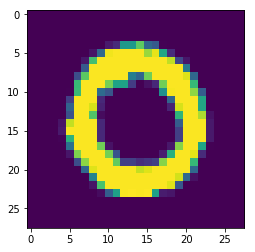

In [162]:
plt.imshow(x_train[1].reshape(28,28))

## scalar standardisation

In [163]:
from sklearn.preprocessing import StandardScaler

In [164]:
scaler = StandardScaler()
scaler.fit(x_train)
x_std_train = scaler.transform(x_train)
x_std_test = scaler.transform(x_test)

## PCA Decomposition

In [165]:
from sklearn.decomposition import PCA
import numpy as np

Text(0,0.5,'cummulative variance')

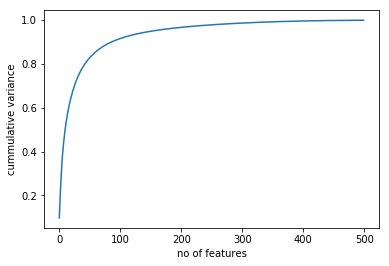

In [166]:
pca = PCA(n_components=500)
pca.fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("no of features")
plt.ylabel("cummulative variance")

In plot above we can see that cumulative explained variance is very high near 100 and then it increases very slowly. That means that data describing changes is mostly contained in 100 components. We need to evaluate trade-offs before we choose number of components we use further. I choose 100 to check how it will work as it seems to have most of the data.

In [176]:
n_components  = 100
pca = PCA(n_components=100)
x_pca_train = pca.fit_transform(x_std_train)
pca_std = np.std(x_pca_train)
x_pca_test = pca.transform(x_std_test)

In [177]:
x_pca_train.shape

(42000, 100)

#### lets see using pca component how image look like

In [174]:
inverted_pca = pca.inverse_transform(x_pca_train)
inv_sca = scaler.inverse_transform(inverted_pca)
inverted_pca.shape

(42000, 784)

In [172]:
inv_sca.shape

(42000, 784)

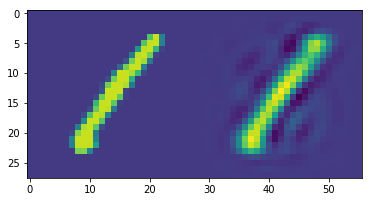

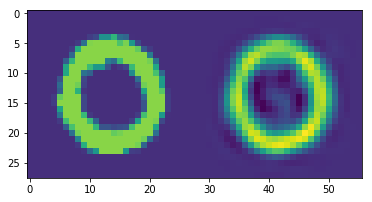

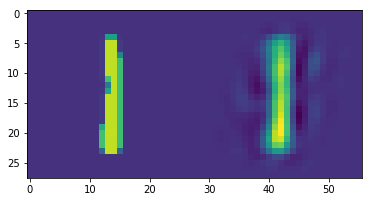

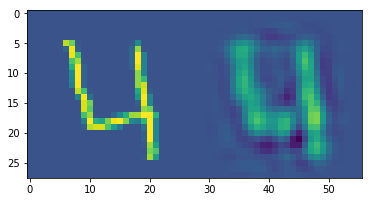

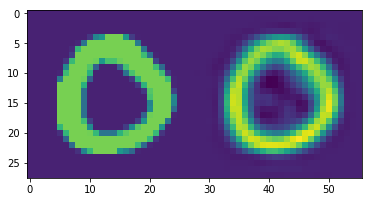

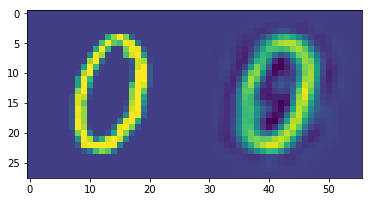

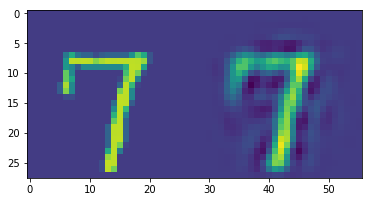

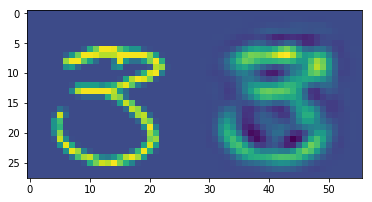

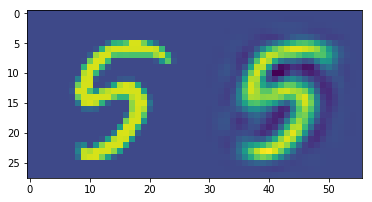

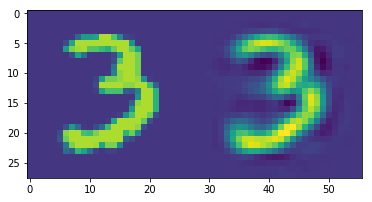

In [169]:
def imshow(indexes):
    org = x_train[indexes].reshape(28,28)
    ref = inv_sca[indexes].reshape(28,28)
    conc = np.concatenate((org,ref) , axis =1)
    plt.Figure(figsize = (4,2))
    plt.imshow(conc)
    plt.show()
for i in range(0,10):
    imshow(i)

After inverting PCA and scaler transform I printed images side by side. It looks like the quality of the reconstructed image decreased in comparison to original, but the numbers are clearly visible. It will depend on the number of components.

## Neural network

In [181]:
from keras.models import Sequential
from keras.layers import Dense ,GaussianNoise,Dropout

In [182]:
model = Sequential()
layers = 1
units = 128

model.add(Dense(units, input_dim=100, activation='relu'))
model.add(GaussianNoise(pca_std))
for i in range(layers):
    model.add(Dense(units, activation='relu'))
    model.add(GaussianNoise(pca_std))
    model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

model.fit(x_pca_train, y_train, epochs=10, batch_size=256, validation_split=0.15, verbose=2)

Train on 35700 samples, validate on 6300 samples
Epoch 1/10
 - 4s - loss: 2.4598 - categorical_accuracy: 0.4953 - val_loss: 0.3869 - val_categorical_accuracy: 0.8933
Epoch 2/10
 - 2s - loss: 0.8274 - categorical_accuracy: 0.7923 - val_loss: 0.3048 - val_categorical_accuracy: 0.9200
Epoch 3/10
 - 2s - loss: 0.5585 - categorical_accuracy: 0.8468 - val_loss: 0.2583 - val_categorical_accuracy: 0.9265
Epoch 4/10
 - 2s - loss: 0.4225 - categorical_accuracy: 0.8757 - val_loss: 0.2172 - val_categorical_accuracy: 0.9348
Epoch 5/10
 - 2s - loss: 0.3432 - categorical_accuracy: 0.8962 - val_loss: 0.1976 - val_categorical_accuracy: 0.9384
Epoch 6/10
 - 2s - loss: 0.3010 - categorical_accuracy: 0.9080 - val_loss: 0.1902 - val_categorical_accuracy: 0.9398
Epoch 7/10
 - 2s - loss: 0.2695 - categorical_accuracy: 0.9168 - val_loss: 0.1663 - val_categorical_accuracy: 0.9498
Epoch 8/10
 - 2s - loss: 0.2395 - categorical_accuracy: 0.9262 - val_loss: 0.1579 - val_categorical_accuracy: 0.9529
Epoch 9/10
 - 2